In [23]:
%matplotlib inline
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras.applications import vgg16

In [49]:
import os
from random import shuffle
from glob import glob

IMG_SIZE = (224, 224)  # размер входного изображения сети

train_files = glob('CVD/train/*.jpg')
test_files = glob('CVD/test/*.jpg')

# загружаем входное изображение и предобрабатываем
def load_image(path, target_size=IMG_SIZE):
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, target_size)
    return vgg16.preprocess_input(img)  # предобработка для VGG16

# функция-генератор загрузки обучающих данных с диска
def fit_generator(files, batch_size=32):
    batch_size = min(batch_size, len(files))
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1. if os.path.basename(path).startswith('dog') else 0.
                          for path in files[i:j]])
            yield (x, y)

# функция-генератор загрузки тестовых изображений с диска
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])

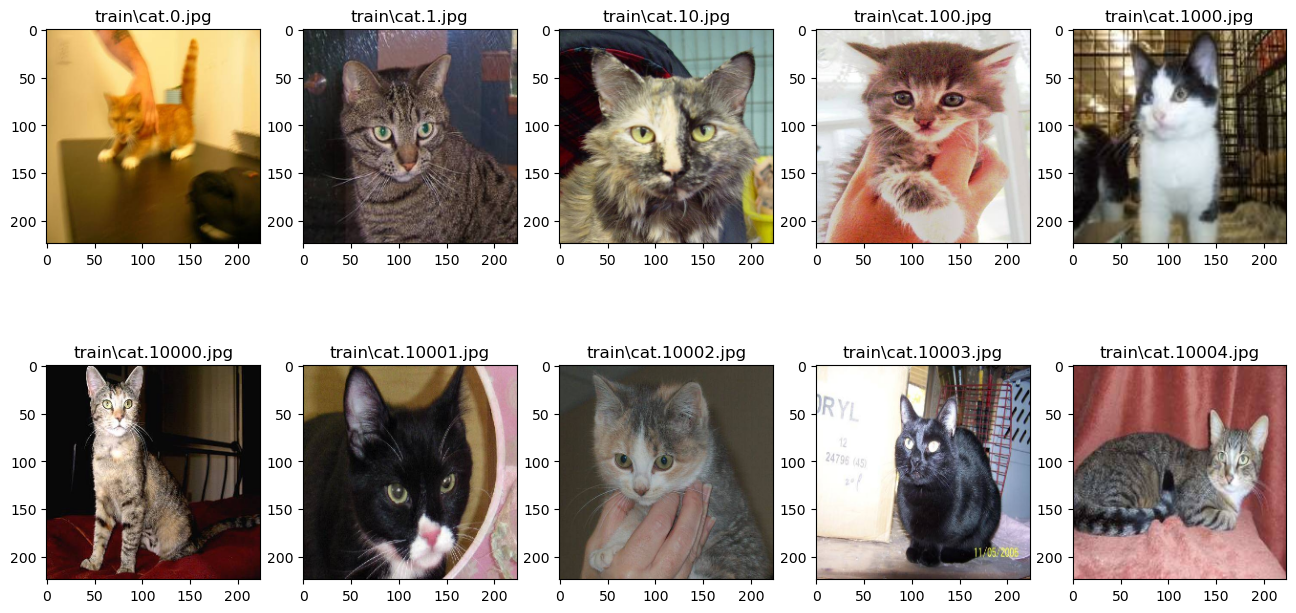

In [17]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(16, 8))
for i, path in enumerate(train_files[:10], 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%s' % path.split('/')[-1])
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    plt.imshow(img)

In [18]:
# base_model - объект класса keras.models.Model (Functional Model)
base_model = vgg16.VGG16(weights='imagenet',
                         include_top=False,
                         input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

58889256/58889256 [==============================] - 7s 0us/step


In [19]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [25]:
# фиксируем все веса предобученной сети
for layer in base_model.layers:
    layer.trainable = False

x = base_model.layers[-1].output
x = Flatten()(x)
x = Dense(8192, activation='relu')(x)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.1)(x)
x = BatchNormalization()(x)
x = Dense(16, activation='relu')(x)
x = Dropout(0.05)(x)
x = tf.keras.layers.Dense(1,  # один выход (бинарная классификация)
                          activation='sigmoid',  # функция активации  
                          kernel_regularizer=tf.keras.regularizers.l1(1e-4))(x)

model = tf.keras.Model(inputs=base_model.input, outputs=x, name='dogs_vs_cats')

In [26]:
model.summary()

Model: "dogs_vs_cats"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)      

In [27]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy',  # функция потерь binary_crossentropy (log loss
              metrics=['accuracy'])

In [28]:
val_samples = 40  # число изображений в валидационной выборке

shuffle(train_files)  # перемешиваем обучающую выборку
validation_data = next(fit_generator(train_files[:val_samples], val_samples))
train_data = fit_generator(train_files[val_samples:])  # данные читаем функцией-генератором

# запускаем процесс обучения
model.fit(train_data,
          steps_per_epoch=10,  # число вызовов генератора за эпоху
          epochs=100,  # число эпох обучения
          validation_data=validation_data)

Epoch 1/100
10/10 [==============================] - 63s 6s/step - loss: 0.2843 - accuracy: 0.8719 - val_loss: 3.8227 - val_accuracy: 0.8250
Epoch 2/100
10/10 [==============================] - 77s 8s/step - loss: 0.1545 - accuracy: 0.9469 - val_loss: 1.5503 - val_accuracy: 0.9250
Epoch 3/100
10/10 [==============================] - 83s 8s/step - loss: 0.1552 - accuracy: 0.9406 - val_loss: 1.3959 - val_accuracy: 0.9000
Epoch 4/100
10/10 [==============================] - 80s 8s/step - loss: 0.1012 - accuracy: 0.9594 - val_loss: 0.4417 - val_accuracy: 0.9500
Epoch 5/100
10/10 [==============================] - 75s 8s/step - loss: 0.1087 - accuracy: 0.9531 - val_loss: 0.3336 - val_accuracy: 0.9250
Epoch 6/100
10/10 [==============================] - 76s 8s/step - loss: 0.0910 - accuracy: 0.9656 - val_loss: 0.3190 - val_accuracy: 0.9250
Epoch 7/100
10/10 [==============================] - 75s 8s/step - loss: 0.0929 - accuracy: 0.9719 - val_loss: 0.1463 - val_accuracy: 0.9750
Epoch 8/100
1

KeyboardInterrupt: 

In [29]:
model.save('cats-dogs-vgg16.hdf5')

In [30]:
test_pred = model.predict(
    predict_generator(test_files), steps=len(test_files))

201/201 [==============================] - 53s 253ms/step


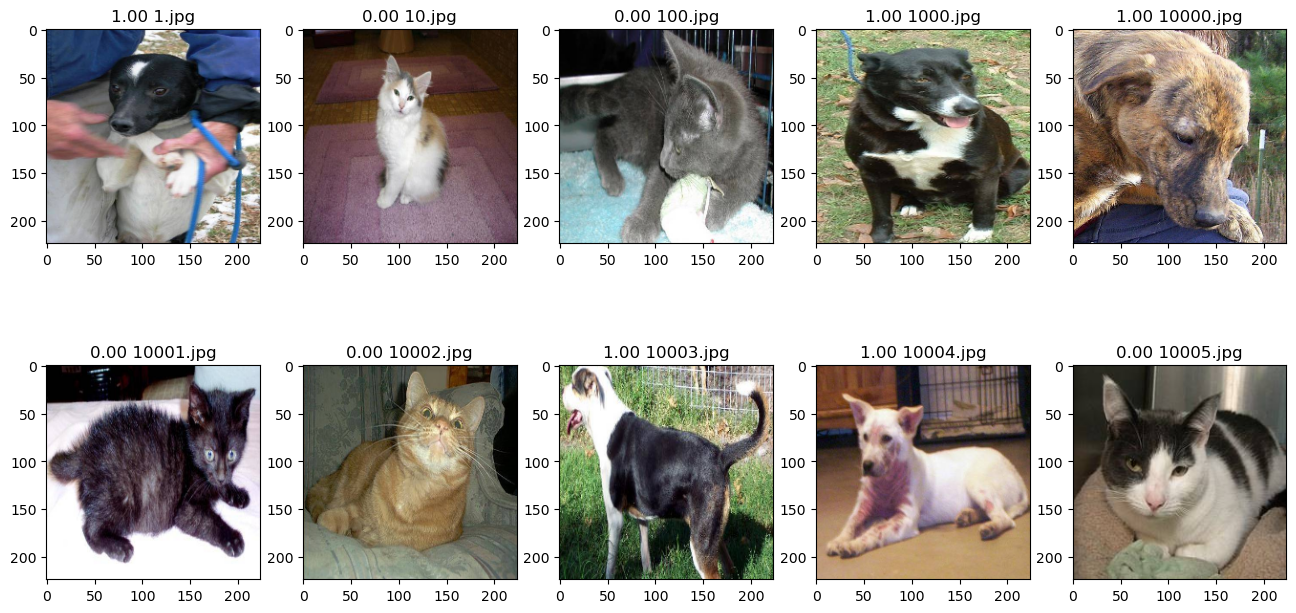

In [31]:
fig = plt.figure(figsize=(16, 8))
for i, (path, score) in enumerate(zip(test_files[:10], test_pred[:10]), 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%.2f %s' % (score, os.path.basename(path)))
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    subplot.imshow(img)

In [32]:
import re

with open('submit.txt', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_files, test_pred):
        dst.write('%s,%f\n' % (re.search('(\d+).jpg$', path).group(1), score))

In [52]:
len(train_files)

25000

In [79]:
from sklearn.metrics import log_loss

shuffle(train_files)  # перемешиваем обучающую выборку
y_test = np.array([1. if os.path.basename(path).startswith('dog') else 0.
                          for path in train_files[:1000]])

y_pred = model.predict(
    predict_generator(train_files[:1000]), steps=1000)

y_pred = [sc[0] for sc in y_pred]

1000/1000 [==============================] - 227s 227ms/step


In [80]:
print(log_loss(y_test, y_pred, eps = 10e-8))

0.07791905865764778


# Я не смог ничего загрузить на каггл из-за ограничений по российским аккаунтам, поэтому вывел все метрики здесь.